# Pandas VS Polars
This notebook shows the difference between using Pandas and Polars. The objective is to demonstrate how Polars performs faster than Pandas.

## Environment set up

Change the working directory to be able to work with the source-code of this repository.

In [1]:
import os
from pathlib import Path

WORKING_DIRECTORY = Path.cwd().parents[0]
os.chdir(WORKING_DIRECTORY)

## Imports

In [2]:
import pandas as pd
from typing import List, Union, Tuple
from src.signals import get_resolution
from loguru import logger
from src.read import read_nasa_vibration_files_in_directory
import numpy as np
import time
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

## Functions
The following function is built in pandas to later compare its performance with the Polars function, which is the library used in this repository:

In [3]:
def drop_pandas_faulty_sensor_data(df: pd.DataFrame, 
                                   sensors: List[str],
                                   acceptable_range: float) -> pd.DataFrame:
    """
    Drop sensor columns if their value range is below the acceptable threshold.

    :param df: input DataFrame containing sensor data
    :param sensors: list of sensor column names to check
    :param acceptable_range: minimum required range for sensor values
    :return: DataFrame without faulty sensor columns
    """
 
    faulty_sensors = [
        sensor for sensor in sensors 
        if (df[sensor].max() - df[sensor].min()) < acceptable_range
    ]

    if set(faulty_sensors) == set(sensors):
        return pd.DataFrame()
    
    return df.drop(columns=faulty_sensors)

In [4]:
def read_pandas_nasa_vibration_file(file_path: Path, sensors: List[str],
                                    signal_resolution: Union[int, float],
                                    acceptable_sensor_range: Union[float, None]=None,
                                    return_file_reading_time: bool = False) -> Union[pd.DataFrame, Tuple[pd.DataFrame, float]]:
    """
    Read one vibration file from the IMS Bearing dataset.

    :param file_path: path to the location of the vibration file
    :param sensors: name of the channels or sensors to be used.
    :param signal_resolution: resolution of the signal in seconds
    :param acceptable_sensor_range: if provided, sensors with a value range below this threshold will be set to pd.NA
    :param return_file_reading_time: If True, returns a tuple of (DataFrame, execution_time_in_seconds)
    :return: Pandas DataFrame or Tuple(DataFrame, float)
    """
    start_time = time.perf_counter()

    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")

    df = pd.read_csv(file_path, sep='\t', header=None, names=sensors)
    df['measurement_time_in_seconds'] = df.index * signal_resolution

    if acceptable_sensor_range is not None:
        df = drop_pandas_faulty_sensor_data(df=df, sensors=sensors, acceptable_range=acceptable_sensor_range)

    end_time = time.perf_counter()
    execution_time = end_time - start_time

    if return_file_reading_time:
        return df, execution_time
    
    return df

In [5]:
def read_pandas_nasa_vibration_files_in_directory(files_path: Path, 
                                                  sensors: List[str],
                                                  signal_resolution: Union[int, float],
                                                  acceptable_sensor_range: Union[float, None]=None,
                                                  return_file_reading_time: bool = False) -> Union[List[pd.DataFrame], Tuple[List[pd.DataFrame], List[float]]]:
    """
    Read all vibration files in a directory and return a list of DataFrames.

    :param files_path: path to the directory containing the vibration files
    :param sensors: name of the channels or sensors to be used.
    :param signal_resolution: resolution of the signal in seconds
    :param acceptable_sensor_range: if provided, sensors with a value range below this threshold will be set to None
    :param return_file_reading_time: If True, returns a tuple of (List[DataFrames], List[loading_durations])
    :return: List of Pandas DataFrames or Tuple(List[DataFrames], List[float])
    """
    list_of_files = os.listdir(files_path)
    number_of_files = len(list_of_files)
    if number_of_files == 0:
        raise ValueError(f"No files found in the directory: {files_path}")
    
    dataframes = []
    durations = []
        
    for file in list_of_files:
        file_path = files_path.joinpath(file)
        
        result = read_pandas_nasa_vibration_file(
            file_path=file_path, 
            sensors=sensors,
            signal_resolution=signal_resolution,
            acceptable_sensor_range=acceptable_sensor_range,
            return_file_reading_time=return_file_reading_time
        )

        if return_file_reading_time:
            df, duration = result
        else:
            df = result

        if df.empty:
            logger.warning(f'All sensors in file {file} are faulty. Skipping this file.')
            continue
            
        df['file_name'] = file
        cols = ['file_name'] + [col for col in df.columns if col != 'file_name']
        df = df[cols]    
        
        dataframes.append(df)
        if return_file_reading_time:
            durations.append(duration)

    number_of_read_files = len(dataframes)
    number_of_discarded_files = number_of_files - number_of_read_files
    
    logger.info(f'{number_of_discarded_files} files were discarded.') 
    logger.info(f'{number_of_read_files} files were read successfully.')

    if return_file_reading_time:
        return dataframes, durations
    
    return dataframes

## Inputs

The inputs have been obtained from the NASA bearings documentation:

In [6]:
INPUTS = {
    '1st_test': {'data_path': 'data/nasa_ims_bearing_dataset/1st_test',
                  'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4',
                                   'channel_5', 'channel_6', 'channel_7', 'channel_8'],
                 'faulty_channels': ['channel_5', 'channel_6', 'channel_7', 'channel_8']},
    '2nd_test': {'data_path': 'data/nasa_ims_bearing_dataset/2nd_test',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4'],
                 'faulty_channels': ['channel_1']},
    '3rd_test': {'data_path': 'data/nasa_ims_bearing_dataset/3rd_test/4th_test/txt',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4'],
                 'faulty_channels': ['channel_3']}
          }

In [7]:
SAMPLING_RATE_IN_HERTZ = 20000
MEASUREMENT_DURATION_IN_SECONDS = 1
ACCEPTABLE_SENSOR_RANGE = 0.01

In [8]:
signal_resolution = get_resolution(sampling_frequency=SAMPLING_RATE_IN_HERTZ)
print(f"Signal resolution: {signal_resolution} seconds")

Signal resolution: 5e-05 seconds


## Read the data

In [9]:
complete_data_path_per_test = {}

for test, inputs_per_test in INPUTS.items():
    for key, values in inputs_per_test.items():
        data_path = inputs_per_test['data_path']
        complete_path = WORKING_DIRECTORY.joinpath(data_path)
        complete_data_path_per_test[test] = complete_path

In [10]:
list_of_files =  os.listdir(complete_data_path_per_test['1st_test']) + os.listdir(complete_data_path_per_test['2nd_test']) + os.listdir(complete_data_path_per_test['3rd_test'])
number_of_files = len(list_of_files)
print(f"Number of files to be processed: {number_of_files}")

Number of files to be processed: 3760


### Pandas

In [11]:
df_pandas_list_per_test = {}
for test, file_path in complete_data_path_per_test.items():
    logger.info(f'test: {test}')
    column_names = INPUTS[test]['column_names']
    df_list = read_pandas_nasa_vibration_files_in_directory(files_path=file_path, 
                                                            sensors=column_names,
                                                            signal_resolution=signal_resolution,
                                                            acceptable_sensor_range=ACCEPTABLE_SENSOR_RANGE,
                                                            return_file_reading_time=True)
    df_pandas_list_per_test[test] = df_list

2026-01-11 22:22:07.280 | INFO     | __main__:<module>:3 - test: 1st_test
2026-01-11 22:22:19.786 | INFO     | __main__:read_pandas_nasa_vibration_files_in_directory:55 - 0 files were discarded.
2026-01-11 22:22:19.786 | INFO     | __main__:read_pandas_nasa_vibration_files_in_directory:56 - 1092 files were read successfully.
2026-01-11 22:22:19.787 | INFO     | __main__:<module>:3 - test: 2nd_test
2026-01-11 22:22:23.739 | WARNING  | __main__:read_pandas_nasa_vibration_files_in_directory:41 - All sensors in file 2004.02.19.06.22.39 are faulty. Skipping this file.
2026-01-11 22:22:26.201 | WARNING  | __main__:read_pandas_nasa_vibration_files_in_directory:41 - All sensors in file 2004.02.19.06.12.39 are faulty. Skipping this file.
2026-01-11 22:22:26.793 | INFO     | __main__:read_pandas_nasa_vibration_files_in_directory:55 - 2 files were discarded.
2026-01-11 22:22:26.794 | INFO     | __main__:read_pandas_nasa_vibration_files_in_directory:56 - 982 files were read successfully.
2026-01-1

### Polars

In [12]:
df_polars_list_per_test = {}
for test, file_path in complete_data_path_per_test.items():
    logger.info(f'test: {test}')
    column_names = INPUTS[test]['column_names']
    df_list = read_nasa_vibration_files_in_directory(files_path=file_path, 
                                                     sensors=column_names,
                                                     signal_resolution=signal_resolution,
                                                     acceptable_sensor_range=ACCEPTABLE_SENSOR_RANGE,
                                                     return_file_reading_time=True)
    df_polars_list_per_test[test] = df_list

2026-01-11 22:22:38.935 | INFO     | __main__:<module>:3 - test: 1st_test
2026-01-11 22:22:41.161 | INFO     | src.read:read_nasa_vibration_files_in_directory:102 - 0 files were discarded.
2026-01-11 22:22:41.162 | INFO     | src.read:read_nasa_vibration_files_in_directory:103 - 1092 files were read successfully.
2026-01-11 22:22:41.162 | INFO     | __main__:<module>:3 - test: 2nd_test
2026-01-11 22:22:41.781 | WARNING  | src.read:read_nasa_vibration_files_in_directory:88 - All sensors in file 2004.02.19.06.22.39 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.
2026-01-11 22:22:42.168 | WARNING  | src.read:read_nasa_vibration_files_in_directory:88 - All sensors in file 2004.02.19.06.12.39 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.
2026-01-11 22:22:42.262 | INFO     | src.read:read_nasa_vibration_files_in_directory:102 - 2 files were discarded.
2026-01-11 22:22:42.262 | INFO     | src.read:read_nasa_vibration_files_in_d

## Loading times

In [13]:
tests = list(INPUTS.keys())

file_reading_time_stats = {}

for test in tests:
    print('------------------------------------------------------------------------------------------------------------------------')
    print(f'Results for the {test}:')
    polars_file_reading_time = df_polars_list_per_test[test][1]
    pandas_file_reading_time = df_pandas_list_per_test[test][1]
    polars_number_of_files = len(polars_file_reading_time)
    pandas_number_of_files = len(pandas_file_reading_time)
    sum_polars_file_reading_time = np.sum(polars_file_reading_time)
    sum_pandas_file_reading_time = np.sum(pandas_file_reading_time)    
    max_polars_file_reading_time = np.max(polars_file_reading_time)
    max_pandas_file_reading_time = np.max(pandas_file_reading_time)    
    min_polars_file_reading_time = np.min(polars_file_reading_time)
    min_pandas_file_reading_time = np.min(pandas_file_reading_time)    
    mean_polars_file_reading_time = np.mean(polars_file_reading_time)
    mean_pandas_file_reading_time = np.mean(pandas_file_reading_time)     
    std_polars_file_reading_time = np.std(polars_file_reading_time)
    std_pandas_file_reading_time = np.std(pandas_file_reading_time)  
    sum_pandas_polars_ratio = sum_pandas_file_reading_time / sum_polars_file_reading_time
    max_pandas_polars_ratio = max_pandas_file_reading_time / max_polars_file_reading_time
    min_pandas_polars_ratio = min_pandas_file_reading_time / min_polars_file_reading_time
    mean_pandas_polars_ratio = mean_pandas_file_reading_time / mean_polars_file_reading_time
    std_pandas_polars_ratio = std_pandas_file_reading_time / std_polars_file_reading_time
    file_reading_time_stats[test] = {
        'pandas': {
            'number_of_files': pandas_number_of_files,
            'sum': sum_pandas_file_reading_time,
            'max': max_pandas_file_reading_time,
            'min': min_pandas_file_reading_time,
            'mean': mean_pandas_file_reading_time,
            'std': std_pandas_file_reading_time
        },
        'polars': {
            'number_of_files': polars_number_of_files,
            'sum': sum_polars_file_reading_time,
            'max': max_polars_file_reading_time,
            'min': min_polars_file_reading_time,
            'mean': mean_polars_file_reading_time,
            'std': std_polars_file_reading_time
        }
    }

    print(f'Pandas file reading time - number of files: {pandas_number_of_files}, sum: {sum_pandas_file_reading_time:.4f}s, max: {max_pandas_file_reading_time:.4f}s, min: {min_pandas_file_reading_time:.4f}s, mean: {mean_pandas_file_reading_time:.4f}s, std: {std_pandas_file_reading_time:.4f}s')
    print(f'Polars file reading time - number of files: {polars_number_of_files}, sum: {sum_polars_file_reading_time:.4f}s, max: {max_polars_file_reading_time:.4f}s, min: {min_polars_file_reading_time:.4f}s, mean: {mean_polars_file_reading_time:.4f}s, std: {std_polars_file_reading_time:.4f}s') 
    print(f'Pandas vs Polars ratio - sum: {sum_pandas_polars_ratio:.1f}, max: {max_pandas_polars_ratio:.1f}, min: {min_pandas_polars_ratio:.1f}, mean: {mean_pandas_polars_ratio:.1f}, std: {std_pandas_polars_ratio:.1f}') 


------------------------------------------------------------------------------------------------------------------------
Results for the 1st_test:
Pandas file reading time - number of files: 1092, sum: 11.8215s, max: 0.0264s, min: 0.0101s, mean: 0.0108s, std: 0.0007s
Polars file reading time - number of files: 1092, sum: 2.0572s, max: 0.0049s, min: 0.0017s, mean: 0.0019s, std: 0.0001s
Pandas vs Polars ratio - sum: 5.7, max: 5.4, min: 5.8, mean: 5.7, std: 6.0
------------------------------------------------------------------------------------------------------------------------
Results for the 2nd_test:
Pandas file reading time - number of files: 982, sum: 6.4721s, max: 0.0117s, min: 0.0060s, mean: 0.0066s, std: 0.0004s
Polars file reading time - number of files: 982, sum: 0.9892s, max: 0.0013s, min: 0.0009s, mean: 0.0010s, std: 0.0000s
Pandas vs Polars ratio - sum: 6.5, max: 9.3, min: 6.7, mean: 6.5, std: 8.9
-----------------------------------------------------------------------------

In [14]:
df_list = []

for test in tests:
    df = pd.DataFrame(file_reading_time_stats[test]).rename(columns={'pandas': f'{test}_pandas', 'polars': f'{test}_polars'})
    df_list.append(df)

concat_df = pd.concat(df_list, axis=1)
pandas_df = concat_df.filter(like='pandas', axis=1)
polars_df = concat_df.filter(like='polars', axis=1)

total_pandas_loading_time = pandas_df.T['sum'].sum()
total_polars_loading_time = polars_df.T['sum'].sum()
number_of_pandas_files = int(pandas_df.T['number_of_files'].sum())
number_of_polars_files = int(polars_df.T['number_of_files'].sum())
pandas_polars_loading_time_ratio = total_pandas_loading_time / total_polars_loading_time

print(f'Total number of Pandas files loaded: {number_of_pandas_files}')
print(f'Total Pandas loading time: {total_pandas_loading_time:.4f}s')
print(f'Total number of Polars files loaded: {number_of_polars_files}')
print(f'Total Polars loading time: {total_polars_loading_time:.4f}s')
print(f'Pandas vs Polars loading time ratio: {pandas_polars_loading_time_ratio:.1f}')

Total number of Pandas files loaded: 3758
Total Pandas loading time: 29.5206s
Total number of Polars files loaded: 3758
Total Polars loading time: 4.7425s
Pandas vs Polars loading time ratio: 6.2


## Plots

The following cells display the differences between the Pandas and Polars file loading times:

In [15]:
plot_dfs = []
for test in tests:
    plot_df = pd.DataFrame(pd.DataFrame(file_reading_time_stats)[test].tolist())
    plot_df['test'] = test
    plot_df.index = ['Pandas', 'Polars']
    plot_dfs.append(plot_df)

concat_plot_df = pd.concat(plot_dfs).reset_index().rename(columns={'index': 'Library', 'sum': 'Sum', 'mean': 'Mean', 'std': 'Std', 'min': 'Min', 'max': 'Max' })
concat_plot_df

,Library,number_of_files,Sum,Max,Min,Mean,Std,test
0,Pandas,1092,11.821513,0.026369,0.010094,0.010826,0.000710,1st_test
1,Polars,1092,2.057203,0.004912,0.001748,0.001884,0.000119,1st_test
2,Pandas,982,6.472107,0.011709,0.005991,0.006591,0.000444,2nd_test
3,Polars,982,0.989152,0.001262,0.000889,0.001007,0.000050,2nd_test
4,Pandas,1684,11.227011,0.032533,0.006060,0.006667,0.000749,3rd_test
5,Polars,1684,1.696100,0.001352,0.000889,0.001007,0.000051,3rd_test


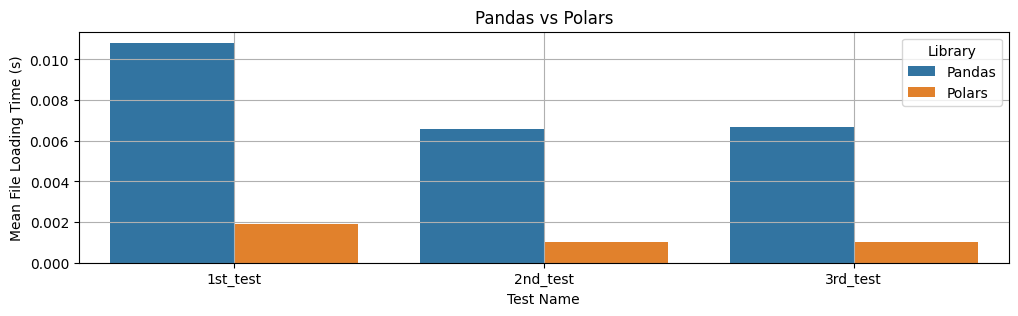

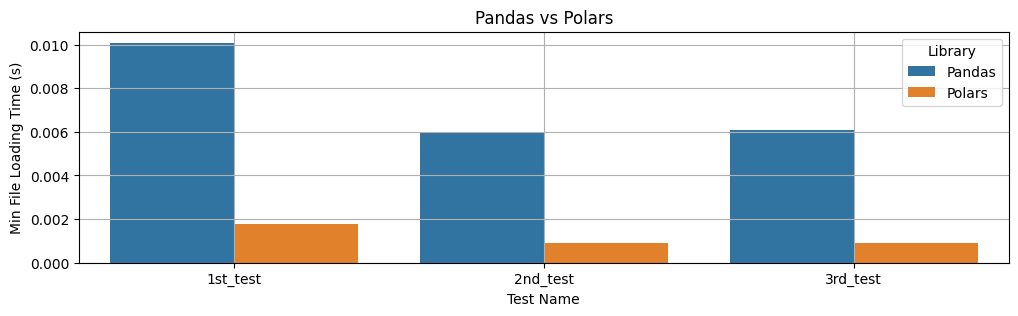

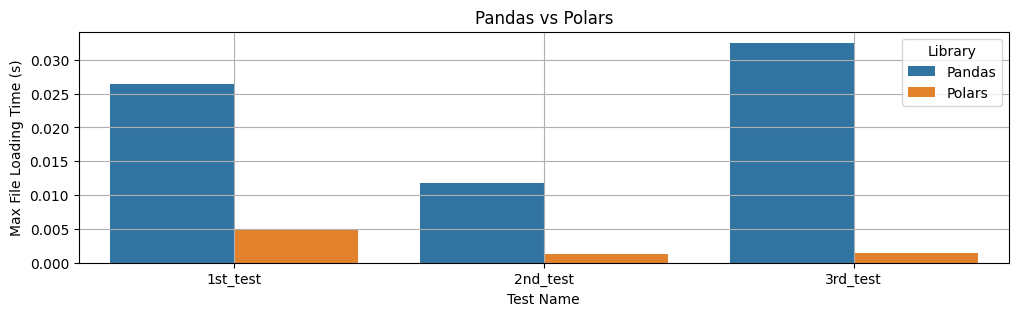

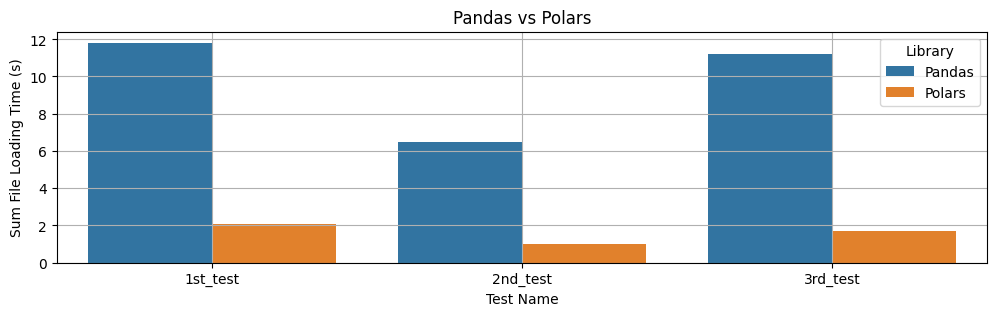

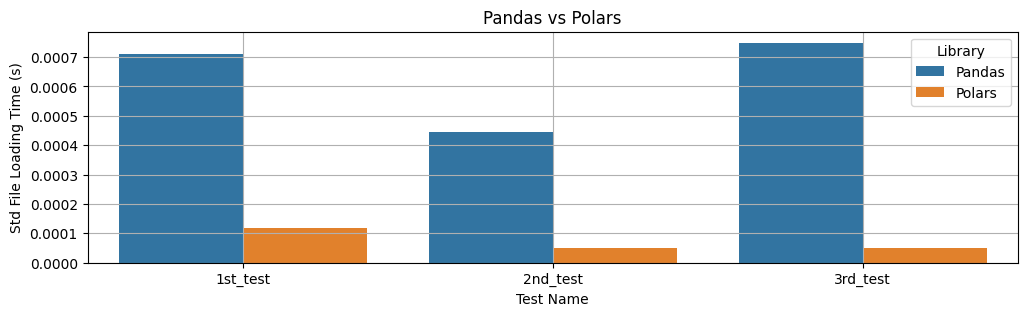

In [16]:
STATS = ['Mean', 'Min', 'Max', 'Sum', 'Std']

for stat in STATS:
    plt.figure(figsize=(12, 3))
    sns.barplot(data=concat_plot_df, x='test', y=stat, hue='Library')
    plt.grid()
    plt.xlabel('Test Name')
    plt.ylabel(f'{stat} File Loading Time (s)')
    plt.title('Pandas vs Polars');

## Result validation
Let's check that the obtained results for Pandas and Polars are the same. For that, a sample will be considered that belongs to the following case:
- 1st_test
- The first measurement

In [17]:
SAMPLE_TEST = '1st_test'
SAMPLE_DATAFRAME = 0 

polars_sample_df = df_polars_list_per_test[SAMPLE_TEST][0][SAMPLE_DATAFRAME]
pandas_sample_df = df_pandas_list_per_test[SAMPLE_TEST][0][SAMPLE_DATAFRAME]

display(polars_sample_df.describe())
display(pandas_sample_df.describe())

statistic,file_name,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,measurement_time_in_seconds
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""20480""",20480.0,20480.0,20480.0,20480.0,20480.0,20480.0,20480.0,20480.0,20480.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,-0.117869,-0.117813,-0.118122,-0.118088,-0.114136,-0.114551,-0.114537,-0.111024,0.511975
"""std""",null,0.099014,0.089247,0.09136,0.076483,0.114354,0.118455,0.074492,0.080365,0.295611
"""min""","""2003.11.15.02.28.46""",-0.708,-0.569,-0.75,-0.547,-0.784,-0.789,-0.432,-0.515,0.0
"""25%""",null,-0.181,-0.176,-0.181,-0.168,-0.188,-0.19,-0.161,-0.161,0.256
"""50%""",null,-0.117,-0.117,-0.117,-0.117,-0.115,-0.115,-0.115,-0.11,0.512
"""75%""",null,-0.054,-0.061,-0.056,-0.068,-0.039,-0.037,-0.068,-0.061,0.76795
"""max""","""2003.11.15.02.28.46""",0.491,0.579,0.229,0.259,0.593,0.469,0.325,0.366,1.02395


,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,measurement_time_in_seconds
count,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000
mean,-0.117869,-0.117813,-0.118122,-0.118088,-0.114136,-0.114551,-0.114537,-0.111024,0.511975
std,0.099014,0.089247,0.091360,0.076483,0.114354,0.118455,0.074492,0.080365,0.295611
min,-0.708000,-0.569000,-0.750000,-0.547000,-0.784000,-0.789000,-0.432000,-0.515000,0.000000
25%,-0.181000,-0.176000,-0.181000,-0.168000,-0.188000,-0.190000,-0.161000,-0.161000,0.255988
50%,-0.117000,-0.117000,-0.117000,-0.117000,-0.115000,-0.115000,-0.115000,-0.110000,0.511975
75%,-0.054000,-0.061000,-0.056000,-0.068000,-0.039000,-0.037000,-0.068000,-0.061000,0.767962
max,0.491000,0.579000,0.229000,0.259000,0.593000,0.469000,0.325000,0.366000,1.023950


All the parameters look the same between Pandas and Polars except the quantiles *25%*,*50%*, and *75%* for the *measurement_time_in_seconds* column.

This numerical discrepancy happens as each library uses a different method for computing the quantiles:
- Pandas defaults to `interpolation="linear"`
    - Calculation: It takes the weighted average of the two nearest points.
- Polars defaults to `interpolation="nearest"` (in older versions) or has slightly different behavior depending on the specific method used.
    - Calculation: It picks the value of the data point physically closest to that percentile.

Hence, if the interpolation parameter is changed in the Polars quantile calculation we will get the same result as in Pandas for the quantiles:

In [18]:
quantile_25 = polars_sample_df.select(pl.col("measurement_time_in_seconds").quantile(0.25, interpolation="linear"))['measurement_time_in_seconds'][0]
quantile_50 = polars_sample_df.select(pl.col("measurement_time_in_seconds").quantile(0.5, interpolation="linear"))['measurement_time_in_seconds'][0]
quantile_75 = polars_sample_df.select(pl.col("measurement_time_in_seconds").quantile(0.75, interpolation="linear"))['measurement_time_in_seconds'][0]

print('Quantiles for measurement_time_in_seconds in Polars sample dataframe using the linear interpolation method:')
print(f'25th percentile: {quantile_25:.6f}')
print(f'50th percentile: {quantile_50:.6f}')
print(f'75th percentile: {quantile_75:.6f}')

Quantiles for measurement_time_in_seconds in Polars sample dataframe using the linear interpolation method:
25th percentile: 0.255988
50th percentile: 0.511975
75th percentile: 0.767962


## Summary

As a conclusion, it is possible to use Polars instead of Pandas while obtaining the same results and getting a faster performance. Nevertheless, it is necessary to understand that there might be some little differences in the results, but they can be understood by going through each packages documentation.